## Controling a Transmon Coupled to a Cavity
from https://sequencing.readthedocs.io/en/latest/notebooks/06-transmon-cavity-control.html

In [19]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import inspect
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import qutip

from sequencing import Transmon, Cavity, System, get_sequence, sync, delay
from sequencing.calibration import fit_sine, fit_displacement, tune_rabi, tune_displacement, tune_drag

In [54]:
qubit = Transmon('qubit', levels=2)
qubit.gaussian_pulse.sigma = 5 # ns
qubit.gaussian_pulse.chop = 4 # sigma
system = System('system', modes=[qubit])

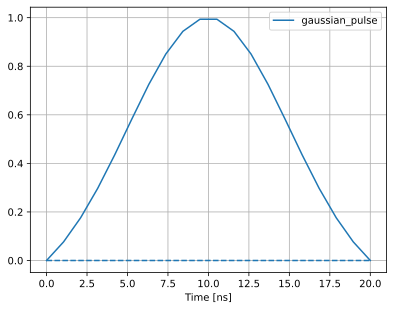

In [55]:
ax = qubit.gaussian_pulse.plot()
_ = ax.set_xlabel('Time [ns]')

In [56]:
pulse_amps = np.linspace(-2, 2, 51)
init_state = qubit.fock(0) # start in |g>
e_ops = [qubit.fock(1)] # measure P(|e>)

In [57]:
e_population = []
for amp in tqdm(pulse_amps, desc='Pulse amp'):
    with qubit.pulse_scale(amp):
        seq = get_sequence(system)
        qubit.rotate_x(np.pi)
        result = seq.run(init_state, e_ops=e_ops)
        e_population.append(result.expect[0][-1])

Pulse amp: 100%|██████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 292.38it/s]


In [58]:
fit_result = fit_sine(pulse_amps, e_population)
optimal_amp = 1 / (2 * fit_result.params['f0'].value)
print('Initial amplitude: 1')
print(f'Optimal scale factor: {optimal_amp:.5f}')

Initial amplitude: 1
Optimal scale factor: 1.05253


In [59]:
qubit.gaussian_pulse.amp = optimal_amp

e_population_final = []
for amp in tqdm(pulse_amps, desc='Pulse amp (after update)'):
    with qubit.pulse_scale(amp):
        seq = get_sequence(system)
        qubit.rotate_x(np.pi)
        result = seq.run(init_state, e_ops=e_ops)
        e_population_final.append(result.expect[0][-1])

Pulse amp (after update): 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 295.76it/s]


In [60]:
fit_result_final = fit_sine(pulse_amps, e_population_final)
optimal_amp_final = 1 / (2 * fit_result_final.params["f0"].value)
print('Initial amplitude: 1', flush=True)
print(f'Optimal scale factor: {optimal_amp_final:.5f}')

Initial amplitude: 1
Optimal scale factor: 1.00000


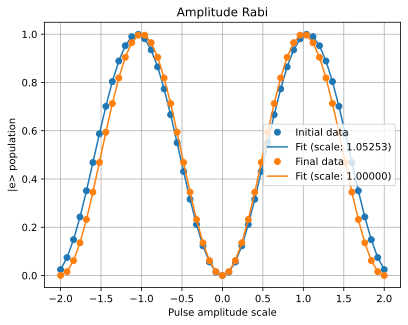

In [61]:
fig, ax = plt.subplots()
ax.plot(
    pulse_amps, e_population, 'C0o', label='Initial data'
)
ax.plot(
    pulse_amps, fit_result.best_fit, 'C0-', label=f'Fit (scale: {optimal_amp:.5f})'
)
ax.plot(
    pulse_amps, e_population_final, 'C1o', label='Final data'
)
ax.plot(
    pulse_amps, fit_result_final.best_fit, 'C1-',
    label=f'Fit (scale: {optimal_amp_final:.5f})'
)
ax.set_xlabel('Pulse amplitude scale')
ax.set_ylabel('|e> population')
ax.set_title('Amplitude Rabi')
ax.grid(True)
_ = ax.legend(loc=0)

In [62]:
seq = get_sequence(system)
qubit.rotate_x(np.pi)
result = seq.run(init_state)

ideal_state = qubit.rotate_x(np.pi, unitary=True) * init_state
fid_g_to_e = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'State fidelity |g> -> |e>: {fid_g_to_e:.5f}')

init_state = qubit.fock(1) # start in |e>
result = seq.run(init_state)
ideal_state = qubit.rotate_x(np.pi, unitary=True) * init_state
fid_e_to_g = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'State fidelity |e> -> |g>: {fid_e_to_g:.5f}')

State fidelity |g> -> |e>: 1.00000
State fidelity |e> -> |g>: 1.00000


In [63]:
print('sequencing.calibration.tune_rabi():')
print('\n\t'.join([''] + inspect.getdoc(tune_rabi).splitlines()))

sequencing.calibration.tune_rabi():

	Tune the amplitude of a Transmon pulse using
	an amplitude-Rabi experiment.
	
	Args:
	    system (System): System containing the Transmon whose
	        pulse you want to tune.
	    init_state (qutip.Qobj): Initial state of the system.
	    e_ops (optional, list[qutip.Qobj]): List of expectation
	        operators. If none, defaults to init_state. Default: None.
	    mode_name (optional, str): Name of the Transmon mode. Default: 'qubit'.
	    pulse_name (optional, str): Name of the pulse to tune. If None,
	        will use transmon.default_pulse. Default: None.
	    amp_range (optional, tuple[float, float, int]): Range over which to
	        sweep the pulse amplitude, specified by (start, stop, num_steps).
	        The units are such that, if the pulse is tuned up, amplitude of 1
	        generates a rotation by pi. Default: (-2, 2, 51).
	    progbar (optional, bool): Whether to display a tqdm progress bar.
	        Default: True.
	    plot (option